# Self-Driving Car Engineer Nanodegree

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [84]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
validation_file = 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.   
**THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [85]:
import numpy as np
import csv

# Number of training examples
n_train = len(X_train)

# Number of testing examples
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train[0].shape

# Number of unique classes/labels there are in the dataset.
with open('signnames.csv',"r") as f:
    reader = csv.reader(f, delimiter = ",")
    data = list(reader)
    n_classes = len(data) - 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

11


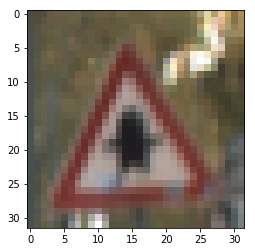

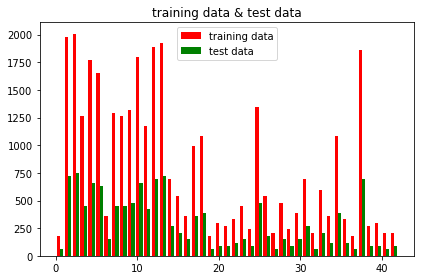

In [86]:
import random
import matplotlib.pyplot as plt

# Visualizations will be shown in the notebook.
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[8955].squeeze()

plt.imshow(image)
print(y_train[8955])

np.random.seed(0)

n_bins = 43
x = y_train, y_test
fig, ax = plt.subplots(nrows=1, ncols=1)

colors = ['red', 'green']
labels = ['training data', 'test data']
ax.hist(x, bins=n_bins, histtype='bar', color=colors, label=labels)
ax.legend(prop={'size': 10})
ax.set_title('training data & test data')

fig.tight_layout()
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

With the LeNet-5 solution from the lecture, expecting a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

### Pre-process the Data Set (normalization, grayscale, etc.)

(96236, 32, 32, 1)
(32, 32, 1)


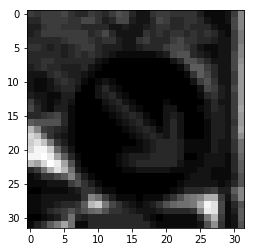

min = 0 - max = 25


In [87]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.

import cv2
from scipy.ndimage import rotate
from sklearn.utils import shuffle

def normalize(img):
    
    # normalize image
    normalizedImg = np.zeros(shape=img.shape)
    normalizedImg = cv2.normalize(img, dst = normalizedImg, alpha=0, beta=25, 
                                  norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    
    # Add back the 3rd dimension
    if len(normalizedImg.shape) < 3:
        normalizedImg = np.expand_dims(normalizedImg, axis= 2)
    return normalizedImg

def generate_additional_data_rotate(x, y):
    for i in range(43):
        indexes = y == i
        count = np.sum(indexes)
        x_train_sample = x[indexes]
        y_train_sample = y[indexes]
        if count < 750:
            # three random angles between -10 to 10 degress
            three_random_angles = 20.0*np.random.random_sample(3) - 10.0
            x1 = rotate(x_train_sample, three_random_angles[0], axes=(1,2), reshape=False)
            x2 = rotate(x_train_sample, three_random_angles[1], axes=(1,2), reshape=False)
            x3 = rotate(x_train_sample, three_random_angles[2], axes=(1,2), reshape=False)
            X_additional = np.concatenate((x1, x2, x3))
            x = np.concatenate((x, X_additional))
            y = np.concatenate((y, y_train_sample, y_train_sample, y_train_sample))
        elif count < 1500:
            # one random angles between -10 to 10 degress
            one_random_angle = 20.0*np.random.random_sample(1) - 10.0
            x1 = rotate(x_train_sample, one_random_angle[0], axes=(1,2), reshape=False)
            x = np.concatenate((x, x1))
            y = np.concatenate((y, y_train_sample))
            
    return x, y

X_train, y_train = generate_additional_data_rotate(X_train, y_train)
X_train, y_train = generate_additional_data_rotate(X_train, y_train)
X_train, y_train = shuffle(X_train, y_train)
    

def ConvertGray(X_gray, X):
    for i in range(X.shape[0]):
        image = cv2.cvtColor(X[i], cv2.COLOR_RGB2GRAY)
        image = normalize(image)
        X_gray.append(image)
    X_gray = np.reshape(X_gray, (-1, 32, 32, 1))
    return X_gray

X_train_gray, X_valid_gray, X_test_gray = [], [], []
X_train_gray = ConvertGray(X_train_gray, X_train)
X_valid_gray = ConvertGray(X_valid_gray, X_valid)
X_test_gray = ConvertGray(X_test_gray, X_test)

print(X_train_gray.shape)
print(X_train_gray[8955].shape)
plt.imshow(X_train_gray[8955].squeeze(), cmap="gray")
plt.show()
print('min =', np.min(X_train_gray[8955]), '- max =', np.max(X_train_gray[8955]))

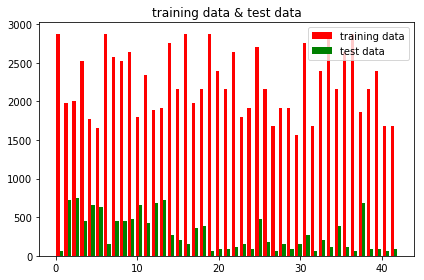

In [88]:
np.random.seed(0)

n_bins = 43
x = y_train, y_test
fig, ax = plt.subplots(nrows=1, ncols=1)

colors = ['red', 'green']
labels = ['training data', 'test data']
ax.hist(x, bins=n_bins, histtype='bar', color=colors, label=labels)
ax.legend(prop={'size': 10})
ax.set_title('training data & test data')

fig.tight_layout()
plt.show()

### Model Architecture

In [89]:
### Define architecture here.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 0
    conv0_W = tf.Variable(tf.truncated_normal(shape = (1, 1, 1, 1), mean = mu, stddev = sigma))
    conv0_b = tf.Variable(tf.zeros(1))
    conv0 = tf.nn.conv2d(x, conv0_W, strides = [1, 1, 1, 1], padding = 'SAME') + conv0_b
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape = (5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(conv0, conv1_W, strides = [1, 1, 1, 1], padding = 'VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape = (5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides = [1, 1, 1, 1], padding = 'VALID') + conv2_b

    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize = [1, 2, 2, 1], strides = [1,2 ,2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)
    """
    The flatten function flattens a Tensor into two dimensions: (batches, length). 
    In this model, the the output shape of Pooling Layer 2 should be 5x5x16, which equals 400.  
    """
   
    # Dropout
    fc0 = tf.nn.dropout(fc0, 0.75)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape = (400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1 = tf.nn.relu(fc1)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal(shape = (120, 84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2 = tf.nn.relu(fc2)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W = tf.Variable(tf.truncated_normal(shape = (84, 43), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [90]:
### Train model here.
### Calculate and report the accuracy on the training and validation set.

EPOCHS = 20
BATCH_SIZE = 128

x = tf.placeholder(tf.float32, shape = (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32, [])
rate = 0.001

logits = LeNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, keep_prob):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        batch_x = np.reshape(batch_x, (-1, 32, 32, 1))
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_gray)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_gray, y_train = shuffle(X_train_gray, y_train)
        X_valid_gray, y_valid = shuffle(X_valid_gray, y_valid)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_gray[offset:end], y_train[offset:end]
            batch_x = np.reshape(batch_x, (-1, 32, 32, 1))
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.7})
        
        train_accuracy = evaluate(X_train_gray, y_train, keep_prob)
        validation_accuracy = evaluate(X_valid_gray, y_valid, keep_prob)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    test_accuracy = evaluate(X_test_gray, y_test, keep_prob)
    print("Test accuracy = {:.3f}".format(test_accuracy))
        
    saver.save(sess, './lenet')
    print("Model saved")
    

Training...

EPOCH 1 ...
Training Accuracy = 0.934
Validation Accuracy = 0.848

EPOCH 2 ...
Training Accuracy = 0.967
Validation Accuracy = 0.886

EPOCH 3 ...
Training Accuracy = 0.979
Validation Accuracy = 0.907



KeyboardInterrupt: 

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

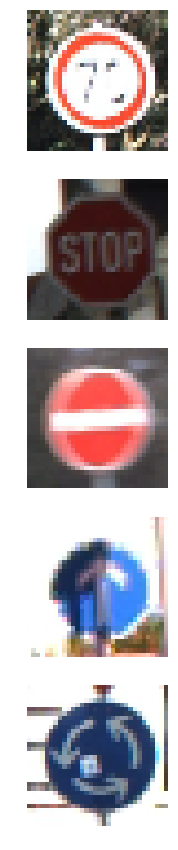

In [7]:
### Load the images and plot them here.
from PIL import Image
import matplotlib.image as mpimg

fig = plt.gcf()
fig.set_size_inches(15, 15)
subdir = 'test_images/'
fname = ['4.jpg','14.jpg','17.jpg','35.jpg','40.jpg']

test_images = np.zeros((5,32,32,3), dtype=np.uint8)
for i in range(5):
    image = mpimg.imread(subdir + fname[i])
    image = cv2.resize(image, (32, 32))
    test_images[i] = image
    plt.subplot(5, 1, i + 1)
    plt.imshow(image)
    plt.axis('off')

test_images = normalize(test_images)
test_images_gray = []
for i in range(5):
    image = cv2.cvtColor(test_images[i], cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = image.astype(np.float32)
    test_images_gray.append(image)

test_images_gray = np.reshape(test_images_gray, (-1, 32, 32, 1))
test_images_gray = np.asarray(test_images_gray)

### Predict the Sign Type for Each Image

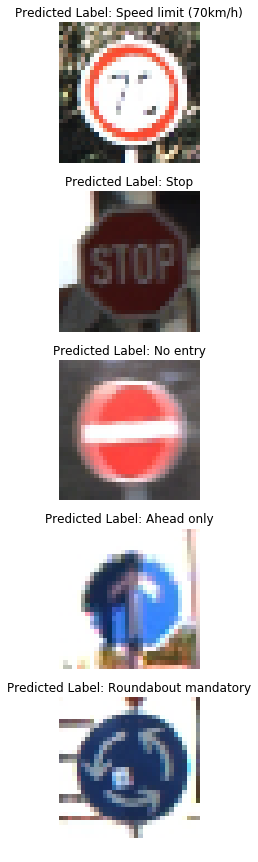

In [8]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
fig = plt.gcf()
fig.set_size_inches(15, 15)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    prediction = tf.argmax(logits, 1)
    test_prediction = sess.run(prediction, feed_dict={x: test_images_gray, keep_prob: 1.0})
    
with open('signnames.csv', 'r') as f:
    reader = csv.reader(f)
    class_names = dict(reader)
    
for i in range(5):
    image = mpimg.imread(subdir + fname[i])
    image = cv2.resize(image, (32, 32))
    plt.subplot(5, 1, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Predicted Label: {}".format(class_names[str(test_prediction[i])]))

### Analyze Performance

In [9]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
test_labels = np.array([4, 14, 17, 35, 40])
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(test_images_gray, test_labels, keep_prob)
    print("Image Test Accuracy = {:.1f}".format(test_accuracy))

Image Test Accuracy = 1.0


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

TopKV2(values=array([[  9.99994636e-01,   5.31746582e-06,   3.18846709e-08,
          6.17436191e-09,   2.81731238e-09],
       [  9.99997497e-01,   1.00386808e-06,   5.35161462e-07,
          4.70022741e-07,   1.97316240e-07],
       [  1.00000000e+00,   1.13605634e-16,   8.69719451e-18,
          5.03393418e-18,   7.50242088e-20],
       [  9.99996424e-01,   1.37216023e-06,   1.13219357e-06,
          3.16615456e-07,   3.11881337e-07],
       [  9.91586924e-01,   8.28470197e-03,   5.34070714e-05,
          3.71076312e-05,   3.37634665e-05]], dtype=float32), indices=array([[ 4,  1, 33, 40, 14],
       [14, 38, 34, 39, 13],
       [17, 33, 14, 40, 13],
       [35, 12, 37, 33, 15],
       [40, 37, 39,  1,  2]], dtype=int32))


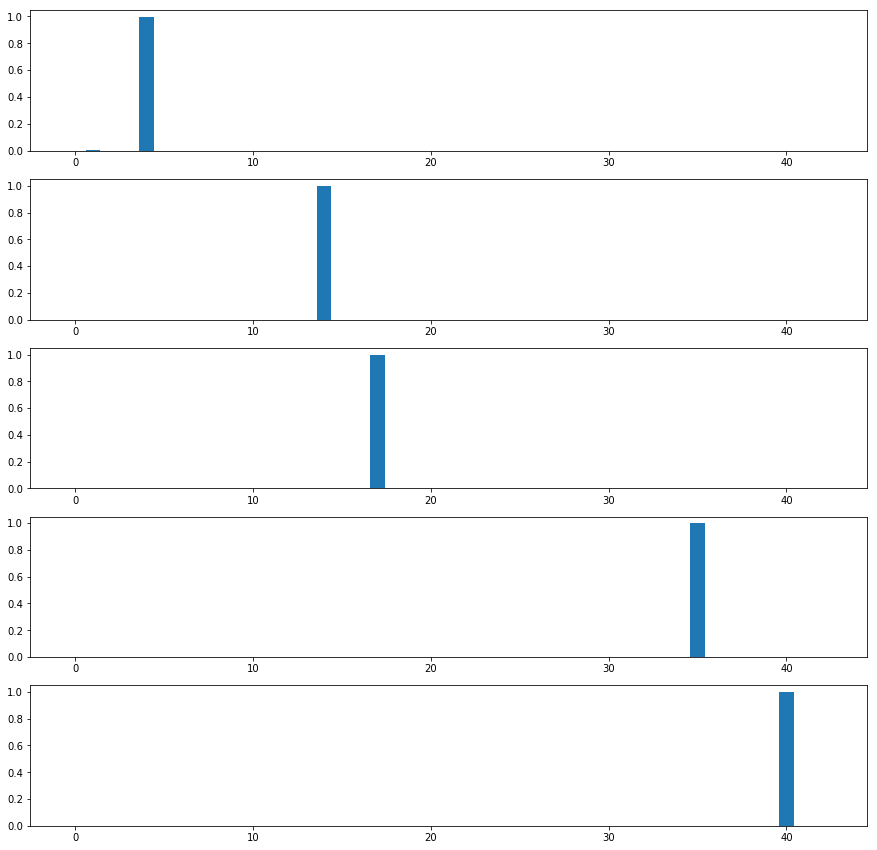

In [10]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=5)
sess2 = tf.get_default_session()

with tf.Session() as sess2:
    sess2.run(tf.global_variables_initializer())
    saver.restore(sess2, tf.train.latest_checkpoint('.'))
    my_softmax_logits = sess2.run(softmax_logits, feed_dict={x: test_images_gray, keep_prob: 1.})
    my_top_k = sess2.run(top_k, feed_dict={x: test_images_gray, keep_prob: 1.})

print(my_top_k)    
fig = plt.figure()
fig.set_size_inches(15, 15)
x_vals = range(43)
for i in range(5):
    ax = fig.add_subplot(5,1, i + 1)
    ax.bar(x_vals, my_softmax_logits[i])
plt.show()

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [11]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 